# Neurotransmitter Assignment Analysis

This notebook performs comprehensive neurotransmitter (NT) classification and comparative analysis between induced neurons (iNeurons) and primary neuron atlas data. The analysis aims to:

1. **Classify neuron clusters** by neurotransmitter type using gene expression signatures
2. **Compare iNeuron vs primary neuron** expression patterns across brain regions
3. **Validate NT assignments** through automated and manual annotation approaches
4. **Generate region-specific markers** for different neurotransmitter types
5. **Visualize expression patterns** across experimental conditions and brain regions

## Key Methods:
- **Automated NT classification**: Using AUCell scores and regulon-based analysis
- **Differential expression analysis**: Wilcoxon rank-sum tests for marker identification
- **Cross-species comparison**: Human primary vs mouse primary vs iNeurons
- **Expression visualization**: Heatmaps and correlation analysis

## Neurotransmitter Systems Analyzed:
- **Glutamatergic**: Excitatory neurons (SLC17A6/7/8, SLC1A1/2/6)
- **GABAergic**: Inhibitory neurons (GAD1/2, SLC32A1, SLC6A1)
- **Cholinergic**: Acetylcholine neurons (CHAT, SLC18A3, ACHE)
- **Dopaminergic**: Dopamine neurons (TYR, DDC, SLC18A2)
- **Noradrenergic**: Norepinephrine neurons (DBH, SLC6A2)
- **Glycinergic**: Glycine neurons (SLC6A5/9)
- **Other monoaminergic**: Serotonergic, histaminergic, adrenergic

## 1. Import Libraries and Dependencies

Import necessary libraries for single-cell analysis, visualization, and neurotransmitter classification. This includes scanpy for single-cell analysis, pySCENIC for regulon analysis, and various plotting libraries.

In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import pickle
import re
import seaborn as sns

from pyscenic.aucell import aucell
from pyscenic.utils import Regulon


Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)/cluster/project/treutlein/jjans/software/miniforge3/envs/pyscenic/lib/python3.10/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/cluster/project/treutlein/jjans/software/miniforge3/envs/pyscenic/lib/python3.10/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/re

## 2. Load Combined Atlas Data

Load the integrated single-cell dataset containing both human/mouse primary neurons and iNeuron experiments from multiple studies.

In [2]:
adata = sc.read_h5ad("combined_adata_human_mouse_ineurons.h5ad")

### Extract and Explore Metadata

Extract cell metadata and examine the iNeuron experiment data (Lin_2024 study) to understand cluster composition and experimental conditions.

In [3]:
meta = adata.obs.copy()

In [4]:
meta_ineurons = meta.loc[meta['STUDY']=='Lin_2024']

In [5]:
meta_ineurons['STUDY_CLUSTER'].value_counts().head(n=100)

STUDY_CLUSTER
iGlut_pre_89     13564
iGlut_post_91    11523
iGlut_post_32    10304
iGABA_pre_92      9344
iGABA_post_45     8482
                 ...  
iGABA_pre_41      1726
iGABA_pre_60      1707
iGlut_post_93     1702
iGlut_post_96     1665
iGlut_post_38     1662
Name: count, Length: 100, dtype: int64

## 3. Define Brain Regions for Analysis

Define the brain regions of interest for comparative analysis. These regions represent major divisions of the nervous system where both primary neurons and iNeurons can be compared.

In [6]:
mapped_regions = ['DRG', 'ENS', 'Forebrain','Hindbrain','Midbrain','SPINAL_CORD','SYM','TG','Retina']

In [7]:
adata.obs.loc[adata.obs['STUDY_CLUSTER']=='iGABA_post_45']

,DIVISION,REGION,SUBREGION,SUBSUBREGION,SAMPLE,SPECIES,STUDY,LAB,HARM_CLUSTER,STUDY_CLUSTER,...,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,n_genes,n_counts
iGABA_post_01_02_24__s1,CNS,Forebrain,Forebrain,Forebrain,iGABA_post,HUMAN,Lin_2024,Treutlein,iGABA_post_45,iGABA_post_45,...,7.730175,14.637363,0.0,0.0,0.0,0.0,0.0,0.0,1318,2275.0
iGABA_post_01_31_56__s1,CNS,Forebrain,Forebrain,Forebrain,iGABA_post,HUMAN,Lin_2024,Treutlein,iGABA_post_45,iGABA_post_45,...,8.162802,16.082121,0.0,0.0,0.0,0.0,0.0,0.0,1734,3507.0
iGABA_post_01_40_77__s1,CNS,Forebrain,Forebrain,Forebrain,iGABA_post,HUMAN,Lin_2024,Treutlein,iGABA_post_45,iGABA_post_45,...,8.285766,12.909733,0.0,0.0,0.0,0.0,0.0,0.0,1819,3966.0
iGABA_post_02_50_41__s1,CNS,Forebrain,Forebrain,Forebrain,iGABA_post,HUMAN,Lin_2024,Treutlein,iGABA_post_45,iGABA_post_45,...,8.440528,14.665227,0.0,0.0,0.0,0.0,0.0,0.0,2087,4630.0
iGABA_post_02_51_57__s1,CNS,Forebrain,Forebrain,Forebrain,iGABA_post,HUMAN,Lin_2024,Treutlein,iGABA_post_45,iGABA_post_45,...,7.908387,14.049283,0.0,0.0,0.0,0.0,0.0,0.0,1421,2719.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
iGABA_post_94_57_35__s3,CNS,Forebrain,Forebrain,Forebrain,iGABA_post,HUMAN,Lin_2024,Treutlein,iGABA_post_45,iGABA_post_45,...,7.135687,13.625498,0.0,0.0,0.0,0.0,0.0,0.0,848,1255.0
iGABA_post_94_68_53__s3,CNS,Forebrain,Forebrain,Forebrain,iGABA_post,HUMAN,Lin_2024,Treutlein,iGABA_post_45,iGABA_post_45,...,7.444833,14.561404,0.0,0.0,0.0,0.0,0.0,0.0,1057,1710.0
iGABA_post_96_21_18__s3,CNS,Forebrain,Forebrain,Forebrain,iGABA_post,HUMAN,Lin_2024,Treutlein,iGABA_post_45,iGABA_post_45,...,6.852242,16.825397,0.0,0.0,0.0,0.0,0.0,0.0,628,945.0
iGABA_post_96_51_10__s3,CNS,Forebrain,Forebrain,Forebrain,iGABA_post,HUMAN,Lin_2024,Treutlein,iGABA_post_45,iGABA_post_45,...,8.085178,15.192604,0.0,0.0,0.0,0.0,0.0,0.0,1556,3245.0


In [8]:
adata

AnnData object with n_obs × n_vars = 1287390 × 14598
    obs: 'DIVISION', 'REGION', 'SUBREGION', 'SUBSUBREGION', 'SAMPLE', 'SPECIES', 'STUDY', 'LAB', 'HARM_CLUSTER', 'STUDY_CLUSTER', 'CellID', 'ORIGIN', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'n_counts'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'STUDY_colors', 'log1p'
    layers: 'counts'

### Export Region-Specific Primary Neuron Data

Create separate H5AD files for each brain region containing only human primary neurons. This facilitates region-specific analyses and comparisons.

In [9]:
adata = adata[adata.obs['REGION'].isin(mapped_regions)]

In [67]:
for region in mapped_regions:
    print(region)
    adata_tgdrg = adata[adata.obs['REGION']==region]
    adata_tgdrg = adata_tgdrg[adata_tgdrg.obs['ORIGIN']=='Human_primary']
    adata_tgdrg.write_h5ad("pyscenic/"+region+".h5ad")
del(adata_tgdrg)

DRG


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing 

ENS


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing 

Forebrain


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing 

Hindbrain


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing 

Midbrain


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing 

SPINAL_CORD


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing 

SYM
TG


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing 

Retina


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing 

## 4. Automated Neurotransmitter Classification Functions

### Core Classification Algorithm

Define functions for automated neurotransmitter classification using AUCell (Area Under the Curve) scores and Otsu thresholding. The `auto_classification` function:

1. **Calculates AUCell scores** for each regulon (NT gene set) across all cells
2. **Applies Otsu thresholding** to binarize activity scores
3. **Assigns NT identity** to clusters based on maximum regulon activity
4. **Returns annotations** and activity matrices for downstream analysis

In [11]:
def auto_classification(adata, cluster_key, regulons, key_added='AUTO_CLASS'):
    """
    Automatically classify clusters based on regulon activity using AUCell.

    Parameters:
    -----------
    adata : AnnData
        Annotated data object containing single-cell RNA-seq data.
    cluster_key : str
        Key in `adata.obs` that contains cluster annotations for cells.
    regulons : dict
        Dictionary of regulons (gene sets) used for activity scoring.
    key_added : str, optional
        Key under which the final cluster annotations will be added to `adata.obs`. 
        Default is 'AUTO_CLASS'.

    Returns:
    --------
    adata : AnnData
        Annotated data object with added cluster-level annotations.
    cluster_annotations : dict
        Dictionary mapping cluster IDs to their respective regulon annotations.
    auc_mtx_all : pd.DataFrame
        DataFrame containing AUCell scores for all cells and regulons.
    """
    from pyscenic.aucell import aucell
    import pandas as pd
    import numpy as np
    
    # Copy metadata (cluster assignments, etc.) from adata
    meta = adata.obs.copy()

    # Create a DataFrame of the gene expression matrix from adata.X
    dgem_all = pd.DataFrame.sparse.from_spmatrix(adata.X, index=adata.obs.index, columns=adata.var_names)

    # Compute AUCell scores (regulon activity) for each cell
    auc_mtx_all = aucell(dgem_all, regulons, num_workers=50)

    # Binarize AUCell scores based on thresholds for each regulon
    bin_auc_mtx_all = auc_mtx_all.apply(auto_threshold, axis=0)

    # Initialize a dictionary to store cluster-level annotations
    cluster_annotations = {}

    # Iterate over unique clusters in the dataset
    for cluster in meta[cluster_key].unique():
        # Default annotation is 'unknown'
        cluster_annotations[cluster] = 'unknown'
        
        # Get all cells in the current cluster
        cluster_cells = meta.index[meta[cluster_key] == cluster].tolist()

        if len(cluster_cells) > 0:
            # Calculate the regulon activity ratio for each regulon within the cluster
            cluster_annot = {
                col: np.mean(bin_auc_mtx_all.loc[cluster_cells, col]) for col in auc_mtx_all.columns
            }
            
            # Identify the regulon with the maximum ratio
            max_key = max(cluster_annot, key=cluster_annot.get)
            max_ratio = cluster_annot[max_key]
            
            # Annotate the cluster if the maximum ratio exceeds a threshold (e.g., 0.5)
            if max_ratio > 0.5:
                cluster_annotations[cluster] = max_key

            # Assign the annotation to all cells in the cluster
            meta.loc[cluster_cells, key_added] = cluster_annotations[cluster]
    
    # Update adata.obs with new cluster annotations
    adata.obs = meta

    return adata, cluster_annotations, auc_mtx_all

def auto_threshold(array):
    """
    Apply Otsu's thresholding method to binarize AUCell scores.

    Parameters:
    -----------
    array : pd.Series or np.ndarray
        Series or array of AUCell scores for a regulon.

    Returns:
    --------
    bin_array : np.ndarray
        Binary array indicating whether each score is above the threshold.
    """
    import numpy as np
    from skimage import filters
    
    # Convert the input to a NumPy array if it is not already
    scores = np.asarray(array)

    # Compute Otsu's threshold using skimage
    threshold = filters.threshold_otsu(scores, nbins=1000)

    # Apply the threshold to binarize the scores
    bin_array = scores >= threshold

    return bin_array


## 5. Define Neurotransmitter Gene Signatures (Regulons)

Define gene sets (regulons) for each neurotransmitter system based on key biosynthesis, transport, and signaling genes. These signatures are used for automated classification of neuron clusters.

In [28]:
# Define regulons as gene sets grouped by functional categories
regulons = {
    'glutamate_in': ['SLC1A1', 'SLC1A2', 'SLC1A6'],
    'glutamate_out': ['SLC17A6', 'SLC17A7', 'SLC17A8'],
    'cholinergic': ['SLC18A3', 'CHAT', 'ACHE'],
    'GABAergic': ['GAD1', 'GAD2', 'SLC32A1', 'SLC6A1'],
    'glycinergic': ['SLC6A5', 'SLC6A9'],
    'noradrenergic': ['DBH', 'SLC6A2'],
    'dopaminergic': ['TYR', 'DDC', 'SLC18A2', 'SLC18A3', 'SLC6A2'],
    'adrenergic': ['PNMT'],
    'serotonergic': ['SLC6A4', 'TPH1'],
    'histaminergic': ['HDC'],
    'glial_glutamate': ['SLC1A3', 'SLC1A2']
}

# Define regulons as gene sets grouped by functional categories
regulons = {
    'glutamatergic': ['SLC1A1', 'SLC1A2', 'SLC1A6','SLC17A6', 'SLC17A7', 'SLC17A8'],
    'cholinergic': ['SLC18A3', 'CHAT', 'ACHE'],
    'GABAergic': ['GAD1', 'GAD2', 'SLC32A1', 'SLC6A1'],
    'glycinergic': ['SLC6A5', 'SLC6A9'],
    'noradrenergic': ['DBH', 'SLC6A2'],
    'dopaminergic': ['TYR', 'DDC', 'SLC18A2', 'SLC18A3', 'SLC6A2'],
    'adrenergic': ['PNMT'],
    'serotonergic': ['SLC6A4', 'TPH1'],
    'histaminergic': ['HDC']
}

### Convert Gene Sets to pySCENIC Regulon Format

Convert the neurotransmitter gene dictionaries into pySCENIC Regulon objects, filtering for genes present in the dataset.

In [29]:
#filter marker genes and convert to regulon format
import pyscenic as ps
consensus_regulons = []

for NT in regulons.keys():
    print(NT)
    NT_genes = regulons[NT]
    regulon_dict = {}
    print(NT_genes)
    NT_genes = [x for x in NT_genes if x in adata.var_names]
    print(NT_genes)
    for gene in NT_genes:
        regulon_dict[gene] = 1

    tmp = ps.utils.Regulon(name=NT,
                           gene2weight=regulon_dict,
                           gene2occurrence={},
                           transcription_factor=NT)

    consensus_regulons.append(tmp)


glutamatergic
['SLC1A1', 'SLC1A2', 'SLC1A6', 'SLC17A6', 'SLC17A7', 'SLC17A8']


NameError: name 'adata' is not defined

### Calculate Neurotransmitter Scores Using Scanpy

Use scanpy's gene scoring function to calculate neurotransmitter activity scores for each cell. This provides an alternative scoring method to complement the AUCell approach.

In [14]:
for NT in regulons.keys():
    print(NT)
    NT_genes = regulons[NT]
    regulon_dict = {}
    NT_genes = [x for x in NT_genes if x in adata.var_names]
    print(NT_genes)
    sc.tl.score_genes(adata,
                      gene_list=NT_genes,
                      ctrl_size=50,
                      score_name=NT,
                      random_state=42)

NT_meta = adata.obs.copy()
NT_meta.to_csv("NT_scores_scanpy.tsv",sep="\t")

glutamatergic
['SLC1A1', 'SLC1A2', 'SLC1A6', 'SLC17A6', 'SLC17A7', 'SLC17A8']


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


cholinergic
['CHAT', 'ACHE']
GABAergic
['GAD1', 'GAD2', 'SLC6A1']
glycinergic
['SLC6A5', 'SLC6A9']
noradrenergic
['DBH', 'SLC6A2']
dopaminergic
['TYR', 'DDC', 'SLC18A2', 'SLC6A2']
adrenergic
['PNMT']
serotonergic
['SLC6A4', 'TPH1']
histaminergic
['HDC']


In [202]:
NT_meta = pd.read_csv("NT_scores_scanpy.tsv",sep="\t",index_col=0)

In [203]:
NT_meta.loc[NT_meta['STUDY_CLUSTER']=='iGABA_post_45']

,DIVISION,REGION,SUBREGION,SUBSUBREGION,SAMPLE,SPECIES,STUDY,LAB,HARM_CLUSTER,STUDY_CLUSTER,...,n_counts,glutamatergic,cholinergic,GABAergic,glycinergic,noradrenergic,dopaminergic,adrenergic,serotonergic,histaminergic
iGABA_post_01_02_24__s1,CNS,Forebrain,Forebrain,Forebrain,iGABA_post,HUMAN,Lin_2024,Treutlein,iGABA_post_45,iGABA_post_45,...,2275.0,-0.150397,-0.017026,-0.383768,0.000000,0.000000,-0.008428,0.0,0.0,0.0
iGABA_post_01_31_56__s1,CNS,Forebrain,Forebrain,Forebrain,iGABA_post,HUMAN,Lin_2024,Treutlein,iGABA_post_45,iGABA_post_45,...,3507.0,-0.020167,-0.013621,-0.368976,-0.040453,0.000000,-0.020227,0.0,0.0,0.0
iGABA_post_01_40_77__s1,CNS,Forebrain,Forebrain,Forebrain,iGABA_post,HUMAN,Lin_2024,Treutlein,iGABA_post_45,iGABA_post_45,...,3966.0,-0.210582,-0.050863,0.647168,-0.037766,-0.012589,-0.018883,0.0,0.0,0.0
iGABA_post_02_50_41__s1,CNS,Forebrain,Forebrain,Forebrain,iGABA_post,HUMAN,Lin_2024,Treutlein,iGABA_post_45,iGABA_post_45,...,4630.0,0.177535,-0.011621,0.871619,-0.011505,-0.034516,-0.046021,0.0,0.0,0.0
iGABA_post_02_51_57__s1,CNS,Forebrain,Forebrain,Forebrain,iGABA_post,HUMAN,Lin_2024,Treutlein,iGABA_post_45,iGABA_post_45,...,2719.0,0.158090,-0.031168,0.740118,-0.046285,0.000000,-0.007714,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
iGABA_post_94_57_35__s3,CNS,Forebrain,Forebrain,Forebrain,iGABA_post,HUMAN,Lin_2024,Treutlein,iGABA_post_45,iGABA_post_45,...,1255.0,0.241304,0.000000,-0.247662,0.000000,0.000000,0.000000,0.0,0.0,0.0
iGABA_post_94_68_53__s3,CNS,Forebrain,Forebrain,Forebrain,iGABA_post,HUMAN,Lin_2024,Treutlein,iGABA_post_45,iGABA_post_45,...,1710.0,-0.208530,-0.019434,0.365790,0.000000,0.000000,0.000000,0.0,0.0,0.0
iGABA_post_96_21_18__s3,CNS,Forebrain,Forebrain,Forebrain,iGABA_post,HUMAN,Lin_2024,Treutlein,iGABA_post_45,iGABA_post_45,...,945.0,-0.109607,0.000000,-0.282420,0.000000,0.000000,0.000000,0.0,0.0,0.0
iGABA_post_96_51_10__s3,CNS,Forebrain,Forebrain,Forebrain,iGABA_post,HUMAN,Lin_2024,Treutlein,iGABA_post_45,iGABA_post_45,...,3245.0,-0.164855,-0.042621,0.809466,0.000000,0.000000,-0.014065,0.0,0.0,0.0


## 6. Cluster-Level Neurotransmitter Assignment

### Aggregate NT Scores by Cluster

Calculate mean neurotransmitter scores for each cluster and assign the dominant neurotransmitter type based on highest average score.

In [204]:
NT_cols = ['glutamatergic', 'cholinergic', 'GABAergic', 'glycinergic',
       'noradrenergic', 'dopaminergic', 'adrenergic', 'serotonergic',
       'histaminergic']

In [205]:
NT_meta_clusters = NT_meta.groupby("STUDY_CLUSTER")[NT_cols].mean()

In [206]:
NT_meta_clusters['top_NT'] = NT_meta_clusters.T.idxmax()

### Validate NT Assignments for iNeuron Clusters

Compare automated neurotransmitter assignments for iGABA and iGlut clusters with expected results based on transcription factor induction (ASCL1 vs NGN2).

In [207]:
NT_meta_clusters.loc[[x for x in NT_meta_clusters.index if 'iGABA' in x],'top_NT'].value_counts()

top_NT
GABAergic        78
dopaminergic     15
histaminergic    13
cholinergic      12
noradrenergic     9
serotonergic      2
glutamatergic     1
Name: count, dtype: int64

In [208]:
NT_meta_clusters.loc[[x for x in NT_meta_clusters.index if 'iGlut' in x],'top_NT'].value_counts()

top_NT
glutamatergic    75
cholinergic      30
noradrenergic    19
histaminergic    11
glycinergic       3
serotonergic      2
GABAergic         1
Name: count, dtype: int64

## 7. Integration with Manual Annotations

### Load and Process Manual NT Annotations

Load existing manual neurotransmitter annotations from the literature and standardize terminology for comparison with automated assignments.

In [210]:
annot_meta = pd.read_csv("Table_SX_cluster_information_LT.tsv",sep="\t",index_col=0)
annot_meta['Neuron_type'] = [re.sub("GLUT","glutamatergic",x) for x in annot_meta['Neuron_type']]
annot_meta['Neuron_type'] = [re.sub("CHO","cholinergic",x) for x in annot_meta['Neuron_type']]
annot_meta['Neuron_type'] = [re.sub("NOR","noradrenergic",x) for x in annot_meta['Neuron_type']]
annot_meta['Neuron_type'] = [re.sub("GLY","glycinergic",x) for x in annot_meta['Neuron_type']]
annot_meta['Neuron_type'] = [re.sub("GABA","GABAergic",x) for x in annot_meta['Neuron_type']]
annot_meta['Neuron_type'] = [re.sub("DOPA","dopaminergic",x) for x in annot_meta['Neuron_type']]

In [211]:
annot_meta['Neuron_type'].value_counts()

Neuron_type
GABAergic        104
glutamatergic     88
RGL               54
cholinergic       48
MES               31
noradrenergic     25
NBL               18
EPC               17
glycinergic        3
NCC                3
dopaminergic       3
EPL                2
IP                 2
EC                 2
OB                 1
Name: count, dtype: int64

In [212]:
ngn2_clusters = [x for x in NT_meta_clusters.index if 'iGlut' in x]
ascl1_clusters = [x for x in NT_meta_clusters.index if 'iGABA' in x]
ineuron_clusters = ngn2_clusters + ascl1_clusters

### Compare Automated vs Manual NT Assignments

Evaluate the agreement between automated neurotransmitter assignments and existing manual annotations, particularly for iNeuron clusters.

In [213]:
NT_meta_clusters_ngn2 = NT_meta_clusters.loc[ineuron_clusters].copy()
NT_meta_clusters_ngn2['anno_NT'] = annot_meta.loc[ineuron_clusters,'Neuron_type']

In [ ]:
#overlap of auto NT annotation with manual annotation
np.sum(NT_meta_clusters_ngn2['top_NT']==NT_meta_clusters_ngn2['anno_NT'])/268

0.6977611940298507

In [215]:
annot_meta.loc[annot_meta['Neuron_type']=='dopaminergic']

,Name,Division,Region,Subtype,Neuron_type,top_markers,det_tfs,det_tfs_top2,uniq_tf_marker,det_NTs,...,best_condition,best_condition_purity,DO1,DO1_genes,DO2,DO2_genes,sample,cluster,source_cluster,LT_score
iGABA_post_45,CNS_Forebrain_DOPA:45,CNS,Forebrain,NaN,dopaminergic,"GRIK1, DLX6-AS1, DCC, DSCAM, SLC35F4","ARID5B, NR3C1, THRB, ZNF536, SALL3, SIX3","ARID5B, NR3C1",SIX3,NaN,...,iGABA_post_XAV_3_SHH_1_mTeSR,0.365948,status epilepticus,GRIK1,schizophrenia,GRIK1,iGABA_post,45,iGABA_post_45,0.600688
iGABA_pre_73,CNS_Forebrain_DOPA:POU6F2_CELF4,CNS,Forebrain,NaN,dopaminergic,"GRIA2, POU6F2, CTNNA2, PRKACB, DCC","POU6F2, CELF4, LUZP2, ONECUT1, ZNF536, ZBTB7C,...","POU6F2, CELF4",NaN,"GAD2, GAD1, SLC1A2, SLC1A1, SLC6A1",...,iGABA_pre_XAV_1_SHH_2_N2B27_2Si,0.068149,status epilepticus,GRIA1;NLGN1;SLC8A1;GRIA2;DMD,intellectual disability,DMD;IL1RAPL1;FGF13,iGABA_pre,73,iGABA_pre_73,0.782456
iGABA_pre_92,CNS_Forebrain_DOPA:92,CNS,Forebrain,NaN,dopaminergic,"ADARB2, PTPRD, DSCAM, CNTNAP2, CNTN5","MEIS2, CELF4, KCNIP1, EBF3, ONECUT3, CUX2, ZNF...","MEIS2, CELF4",KCNIP1,"SLC1A2, SLC6A1, SLC1A1",...,iGABA_pre_XAV_3_SHH_2_N2B27_2Si,0.255502,schizophrenia,NRG3;GRIK1;CSMD1;ZNF804A;NRG1;CNTNAP2,status epilepticus,SLC8A1;GRIK1,iGABA_pre,92,iGABA_pre_92,0.799040


In [216]:
NT_meta_clusters_ngn2['anno_NT'].value_counts()

anno_NT
GABAergic        104
glutamatergic     88
cholinergic       48
noradrenergic     25
glycinergic        3
dopaminergic       3
Name: count, dtype: int64

In [217]:
NT_meta_clusters_ngn2['anno_NT'].value_counts()

anno_NT
GABAergic        104
glutamatergic     88
cholinergic       48
noradrenergic     25
glycinergic        3
dopaminergic       3
Name: count, dtype: int64

### Generate Final NT Assignments

Create final neurotransmitter assignments by combining automated classification for primary neurons with manual annotations for iNeuron clusters. This hybrid approach leverages the strengths of both methods.

In [218]:
NT_meta_clusters['final_NT'] = NT_meta_clusters['top_NT']
NT_meta_clusters.loc[NT_meta_clusters_ngn2.index,'final_NT'] = NT_meta_clusters_ngn2['anno_NT']

In [219]:
for cluster in list(set(NT_meta['STUDY_CLUSTER'])):
    NT_meta.loc[NT_meta['STUDY_CLUSTER']==cluster,'NT'] = NT_meta_clusters.loc[cluster,'final_NT']

### Create Regional NT Annotations

Generate comprehensive metadata combining brain region, neurotransmitter type, and experimental origin for downstream comparative analysis.

In [220]:
NT_meta['region_NT'] = NT_meta['REGION'].astype('str')+"_"+NT_meta['NT']

In [221]:
NT_meta['region_NT_origin'] = NT_meta['REGION'].astype('str')+"_"+NT_meta['NT']+"_"+NT_meta['ORIGIN'].astype('str')

In [227]:
NT_meta.loc[NT_meta['region_NT']=='SPINAL_CORD_adrenergic','STUDY'].value_counts()

STUDY
Li_2023        194
Zeisel_2018     15
Name: count, dtype: int64

In [224]:
NT_meta['region_NT'].value_counts()

region_NT
Forebrain_GABAergic          203732
Forebrain_glutamatergic      159303
Hindbrain_GABAergic          103823
Hindbrain_glutamatergic       83994
Midbrain_glutamatergic        67125
Midbrain_GABAergic            66468
Retina_dopaminergic           50743
Forebrain_adrenergic          39227
SPINAL_CORD_glycinergic       37042
SPINAL_CORD_glutamatergic     33129
Forebrain_cholinergic         30291
DRG_glutamatergic             29584
Retina_GABAergic              25852
TG_GABAergic                  24327
SPINAL_CORD_GABAergic         24252
TG_glutamatergic              22344
Forebrain_dopaminergic        19864
Hindbrain_cholinergic         15767
Retina_glutamatergic          15387
Hindbrain_glycinergic         13008
Retina_glycinergic            12637
TG_cholinergic                11688
Forebrain_histaminergic       11565
SPINAL_CORD_cholinergic       10558
Midbrain_cholinergic           9215
TG_noradrenergic               8837
Hindbrain_noradrenergic        7789
Retina_cholinergic

In [35]:
adata.obs = NT_meta.loc[adata.obs.index]

In [36]:
NT_meta.to_csv("NT_meta_use.tsv",sep="\t")

In [10]:
NT_meta = pd.read_csv("NT_meta_use.tsv",sep="\t",index_col=0)

In [11]:
common_cells = list(set(NT_meta.index)&set(adata.obs.index))
adata = adata[common_cells]
adata.obs = NT_meta.loc[adata.obs.index]

## 8. Data Subsampling and Preparation

### Define Subsampling Function

Create a function to subsample cells from each cluster to ensure balanced representation across experimental conditions for fair comparative analysis.

In [12]:
def subsample_adata(adata, column, ncells, seed):
    """
    Subsamples cells based on a column in the metadata and a target number of cells.
    
    Parameters:
    adata : AnnData object
        The AnnData object to be subsampled.
    column : str
        The column in adata.obs to group cells by.
    ncells : int
        The number of cells to sample per group.
    seed : int
        Random seed for reproducibility.

    Returns:
    AnnData object : Subsampled AnnData object.
    """
    unique_groups = adata.obs[column].unique()
    subsampled_cells = []
    
    for group in unique_groups:
        group_cells = adata.obs[adata.obs[column] == group].index
        if len(group_cells) > ncells:
            sampled_cells = np.random.RandomState(seed).choice(group_cells, ncells, replace=False)
        else:
            sampled_cells = group_cells
        subsampled_cells.extend(sampled_cells)
    
    return adata[subsampled_cells, :]

In [13]:
adata_subsampled = subsample_adata(adata,'STUDY_CLUSTER',ncells=500,seed=42)

In [14]:
regions_use = ['DRG','ENS','Forebrain','Hindbrain','Midbrain','SYM','SPINAL_CORD','TG']

In [15]:
mapped_regions

['DRG',
 'ENS',
 'Forebrain',
 'Hindbrain',
 'Midbrain',
 'SPINAL_CORD',
 'SYM',
 'TG',
 'Retina']

In [16]:
adata = adata[adata.obs['REGION'].isin(mapped_regions)]

In [17]:
adata_subsampled.obs['ORIGIN'].value_counts()

ORIGIN
Human_primary    146512
iNeurons         127456
Mouse_primary     15231
Name: count, dtype: int64

In [18]:
NT_meta.loc[adata.obs.index].groupby(['REGION','ORIGIN']).size()

REGION       ORIGIN       
DRG          Human_primary       776
             Mouse_primary      1580
             iNeurons          49340
ENS          Human_primary      2890
             Mouse_primary      1105
             iNeurons           9171
Forebrain    Human_primary    297604
             iNeurons         171275
Hindbrain    Human_primary    146399
             Mouse_primary      5589
             iNeurons          78480
Midbrain     Human_primary     89633
             Mouse_primary      5971
             iNeurons          52284
Retina       Human_primary    114542
SPINAL_CORD  Human_primary     84703
             Mouse_primary      1774
             iNeurons          20892
SYM          Mouse_primary       886
             iNeurons           5447
TG           Human_primary      3870
             iNeurons          63470
dtype: int64

In [19]:
NT_meta.loc[adata_subsampled.obs.index].groupby(['REGION','ORIGIN']).size()

REGION       ORIGIN       
DRG          Human_primary      776
             Mouse_primary     1580
             iNeurons         13658
ENS          Human_primary     2890
             Mouse_primary     1105
             iNeurons          2500
Forebrain    Human_primary    56184
             iNeurons         46308
Hindbrain    Human_primary    33985
             Mouse_primary     4207
             iNeurons         24713
Midbrain     Human_primary    16482
             Mouse_primary     5679
             iNeurons          9730
Retina       Human_primary    20761
SPINAL_CORD  Human_primary    12892
             Mouse_primary     1774
             iNeurons          9973
SYM          Mouse_primary      886
             iNeurons          1681
TG           Human_primary     2542
             iNeurons         18893
dtype: int64

## 9. Differential Expression Analysis

### Region-Specific iNeuron vs Primary Comparison

Perform differential expression analysis comparing iNeurons to primary neurons within each brain region and neurotransmitter type. This identifies genes that are differentially expressed between in vitro and in vivo systems.

In [20]:
import random
random.seed(42)

In [64]:
for region in regions_use:
    print(region)
    adata_clusters = adata_subsampled[adata_subsampled.obs['REGION']==region].copy()

    if region!='SYM':
        adata_clusters = adata_clusters[adata_clusters.obs['ORIGIN'].isin(['Human_primary','iNeurons'])].copy()
    elif region=='SYM':
        adata_clusters = adata_clusters[adata_clusters.obs['ORIGIN'].isin(['Mouse_primary','iNeurons'])].copy()

    cluster_counts = adata_clusters.obs['region_NT_origin'].value_counts()
    cluster_counts_filtered = list(set(cluster_counts[cluster_counts>20].index))
    adata_clusters = adata_clusters[adata_clusters.obs['region_NT_origin'].isin(cluster_counts_filtered)]
    sc.tl.rank_genes_groups(adata_clusters, groupby='region_NT_origin', method='wilcoxon',pts=True)

    de_df_clusters = sc.get.rank_genes_groups_df(adata_clusters,None)
    de_df_clusters.to_csv("NT_comparison/"+region+"_species.tsv",sep="\t")
    

DRG


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing 

ENS


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing 

Forebrain


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing 

Hindbrain


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing 

Midbrain


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing 

SYM


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing 

SPINAL_CORD


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing 

TG


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing 

### Detailed Neurotransmitter Type Comparisons

Perform more granular comparisons within each region-neurotransmitter combination, comparing iNeurons directly to their corresponding primary neuron counterparts.

In [65]:
for region in regions_use:
    print(region)
    adata_clusters = adata_subsampled[adata_subsampled.obs['REGION']==region].copy()

    if region!='SYM':
        adata_clusters = adata_clusters[adata_clusters.obs['ORIGIN'].isin(['Human_primary','iNeurons'])].copy()
    elif region=='SYM':
        adata_clusters = adata_clusters[adata_clusters.obs['ORIGIN'].isin(['Mouse_primary','iNeurons'])].copy()


    cluster_counts = adata_clusters.obs['region_NT_origin'].value_counts()
    cluster_counts_filtered = list(set(cluster_counts[cluster_counts>20].index))
    adata_clusters = adata_clusters[adata_clusters.obs['region_NT_origin'].isin(cluster_counts_filtered)]

    region_NTs = list(set(adata_clusters.obs['region_NT']))
    for region_NT in region_NTs:
        try:
            adata_clusters_NT = adata_clusters[adata_clusters.obs['region_NT']==region_NT].copy()
            sc.tl.rank_genes_groups(adata_clusters_NT, groupby='ORIGIN', method='wilcoxon',pts=True)
            de_df_clusters = sc.get.rank_genes_groups_df(adata_clusters_NT,None)
            de_df_clusters.to_csv("NT_comparison/"+region_NT+"_species.tsv",sep="\t")
        except:
            print(region_NT+" FAILED")

DRG


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


DRG_GABAergic FAILED
DRG_noradrenergic FAILED
DRG_histaminergic FAILED
DRG_glutamatergic FAILED
ENS


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


ENS_GABAergic FAILED
ENS_glutamatergic FAILED
ENS_noradrenergic FAILED
Forebrain
Forebrain_histaminergic FAILED


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass a

Forebrain_adrenergic FAILED


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


Hindbrain


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass a

Hindbrain_histaminergic FAILED


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass a

Hindbrain_serotonergic FAILED


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


Hindbrain_adrenergic FAILED
Midbrain


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


Midbrain_dopaminergic FAILED
Midbrain_glycinergic FAILED


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


Midbrain_histaminergic FAILED
Midbrain_noradrenergic FAILED


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


Midbrain_serotonergic FAILED
SYM


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


SYM_glutamatergic FAILED
SPINAL_CORD


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


SPINAL_CORD_noradrenergic FAILED
SPINAL_CORD_adrenergic FAILED


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass a

SPINAL_CORD_glycinergic FAILED
TG


/cluster/home/jjanssens/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


TG_GABAergic FAILED
TG_histaminergic FAILED
TG_noradrenergic FAILED
TG_glutamatergic FAILED


In [66]:
annot_meta['Neuron_type'].value_counts()

Neuron_type
GABAergic        104
glutamatergic     88
RGL               54
cholinergic       48
MES               31
noradrenergic     25
NBL               18
EPC               17
glycinergic        3
NCC                3
dopaminergic       3
EPL                2
IP                 2
EC                 2
OB                 1
Name: count, dtype: int64

## 10. Expression Matrix Generation

### Define Cluster Expression Function

Create a function to calculate average gene expression and percentage of expressing cells for each cluster. This generates pseudo-bulk expression profiles for visualization and analysis.

In [22]:
def cluster_avg_expr(adata, clustering):
    import warnings
    import pandas as pd
    # DataFrame for average gene expression per cluster
    cluster_avg_subset = pd.DataFrame(columns=adata.var_names, index=adata.obs[clustering].cat.categories)
    
    # DataFrame for the percentage of cells expressing each gene per cluster (based on raw counts)
    cluster_expr_percentage = pd.DataFrame(columns=adata.var_names, index=adata.obs[clustering].cat.categories)
    
    # Check if raw data is available, issue a warning if it's not
    if adata.raw is None:
        warnings.warn("Raw data is not available. Using processed data for expression counts.")
    
    # Loop through each cluster
    for clust in adata.obs[clustering].cat.categories:
        # Subset data for the current cluster
        cluster_data = adata[adata.obs[clustering] == clust]
        
        # Calculate the average expression for each gene
        cluster_avg_subset.loc[clust] = cluster_data.X.mean(0)
        
        # Calculate the percentage of cells expressing each gene (raw counts > 0)
        raw_counts = cluster_data.raw.X if adata.raw is not None else cluster_data.X  # Use raw counts if available
        cell_counts = (raw_counts > 0).sum(0)  # Number of cells expressing each gene
        total_cells = cluster_data.shape[0]  # Total number of cells in the cluster
        
        # Calculate percentage of cells expressing each gene
        cluster_expr_percentage.loc[clust] = (cell_counts / total_cells) * 100
    
    # Convert both DataFrames to float/int as appropriate
    cluster_avg_subset = cluster_avg_subset.astype('float').T  # Transpose so rows are genes, columns are clusters
    cluster_expr_percentage = cluster_expr_percentage.astype('float').T  # Transpose so rows are genes, columns are clusters
    
    return cluster_avg_subset, cluster_expr_percentage



### Generate Combined Expression Matrix

Create comprehensive expression matrices combining all regions, neurotransmitter types, and experimental origins for systematic comparison.

In [23]:
import scanpy as sc
import pandas as pd

# Initialize a list to store DataFrames from each region
SC_expr_list = []
SC_p_list = []

# Loop through each region in regions_use
for region in regions_use:
    print(f"Processing region: {region}")
    
    # Subset the data for the current region
    adata_clusters = adata[adata.obs['REGION'] == region].copy()
    adata_clusters.obs['region_NT_origin'] = adata_clusters.obs['region_NT_origin'].astype('category')
    # Run the average expression function (assumed to be pre-defined)
    SC_expr, SC_p = cluster_avg_expr(adata_clusters, 'region_NT_origin')
    
    # Store the result in a DataFrame and append to the list
    SC_expr_list.append(SC_expr)  # Assuming SC_expr is a DataFrame or can be converted to one
    SC_p_list.append(SC_p)  # Assuming SC_expr is a DataFrame or can be converted to one

# Concatenate all DataFrames into one big DataFrame
SC_expr_combined = pd.concat(SC_expr_list, axis=1)
SC_p_combined = pd.concat(SC_p_list, axis=1)

# Optionally, save the concatenated DataFrame to a file
#big_df.to_csv("concatenated_expression_data.csv", sep="\t")

# If SC_p is also required, you can repeat the process for SC_p or concatenate it similarly.


Processing region: DRG


/scratch/tmp.9491290.jjanssens/ipykernel_79741/3360066722.py:12: UserWarning: Raw data is not available. Using processed data for expression counts.
  warnings.warn("Raw data is not available. Using processed data for expression counts.")


Processing region: ENS


/scratch/tmp.9491290.jjanssens/ipykernel_79741/3360066722.py:12: UserWarning: Raw data is not available. Using processed data for expression counts.
  warnings.warn("Raw data is not available. Using processed data for expression counts.")


Processing region: Forebrain


/scratch/tmp.9491290.jjanssens/ipykernel_79741/3360066722.py:12: UserWarning: Raw data is not available. Using processed data for expression counts.
  warnings.warn("Raw data is not available. Using processed data for expression counts.")


Processing region: Hindbrain


/scratch/tmp.9491290.jjanssens/ipykernel_79741/3360066722.py:12: UserWarning: Raw data is not available. Using processed data for expression counts.
  warnings.warn("Raw data is not available. Using processed data for expression counts.")


Processing region: Midbrain


/scratch/tmp.9491290.jjanssens/ipykernel_79741/3360066722.py:12: UserWarning: Raw data is not available. Using processed data for expression counts.
  warnings.warn("Raw data is not available. Using processed data for expression counts.")


Processing region: SYM


/scratch/tmp.9491290.jjanssens/ipykernel_79741/3360066722.py:12: UserWarning: Raw data is not available. Using processed data for expression counts.
  warnings.warn("Raw data is not available. Using processed data for expression counts.")


Processing region: SPINAL_CORD


/scratch/tmp.9491290.jjanssens/ipykernel_79741/3360066722.py:12: UserWarning: Raw data is not available. Using processed data for expression counts.
  warnings.warn("Raw data is not available. Using processed data for expression counts.")


Processing region: TG


/scratch/tmp.9491290.jjanssens/ipykernel_79741/3360066722.py:12: UserWarning: Raw data is not available. Using processed data for expression counts.
  warnings.warn("Raw data is not available. Using processed data for expression counts.")


In [24]:
SC_expr_combined.to_csv("Region_NT_Origin_expression.tsv",sep="\t")
SC_p_combined.to_csv("Region_NT_Origin_expression_p.tsv",sep="\t")


In [25]:
adata_subsampled = adata_subsampled[adata_subsampled.obs['REGION'].isin(regions_use)]

In [26]:
cluster_counts = adata_subsampled.obs['region_NT'].value_counts()
cluster_counts_filtered = list(set(cluster_counts[cluster_counts>20].index))
adata_subsampled = adata_subsampled[adata_subsampled.obs['region_NT'].isin(cluster_counts_filtered)]

In [27]:
NT_meta.loc[adata_subsampled.obs.index].groupby(['REGION','ORIGIN']).size()

REGION       ORIGIN       
DRG          Human_primary      776
             Mouse_primary     1580
             iNeurons         13658
ENS          Human_primary     2890
             Mouse_primary     1105
             iNeurons          2500
Forebrain    Human_primary    56183
             iNeurons         46308
Hindbrain    Human_primary    33985
             Mouse_primary     4207
             iNeurons         24713
Midbrain     Human_primary    16475
             Mouse_primary     5679
             iNeurons          9730
SPINAL_CORD  Human_primary    12892
             Mouse_primary     1774
             iNeurons          9973
SYM          Mouse_primary      886
             iNeurons          1681
TG           Human_primary     2542
             iNeurons         18893
dtype: int64

### Identify Regional NT Markers

Perform differential expression analysis to identify marker genes for each region-neurotransmitter combination across the full dataset.

In [87]:
sc.tl.rank_genes_groups(adata_subsampled, groupby='region_NT', method='wilcoxon',pts=True)
de_df_clusters = sc.get.rank_genes_groups_df(adata_subsampled,None)

/cluster/home/jjanssens/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self

In [85]:
adata_subsampled

AnnData object with n_obs × n_vars = 268438 × 14598
    obs: 'DIVISION', 'REGION', 'SUBREGION', 'SUBSUBREGION', 'SAMPLE', 'SPECIES', 'STUDY', 'LAB', 'HARM_CLUSTER', 'STUDY_CLUSTER', 'CellID', 'ORIGIN', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'n_counts', 'glutamatergic', 'cholinergic', 'GABAergic', 'glycinergic', 'noradrenergic', 'dopaminergic', 'adrenergic', 'serotonergic', 'histaminergic', 'NT', 'region_NT', 'region_NT_origin'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'STUDY_colors', 'log1p', 'rank_genes_groups'
    layers: 'counts'

In [88]:
de_df_clusters

,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,DRG_GABAergic,SORCS3,89.793617,3.830492,0.0,0.0,0.935809,0.370264
1,DRG_GABAergic,NRCAM,85.302414,2.697525,0.0,0.0,0.941391,0.603410
2,DRG_GABAergic,GULP1,83.913185,3.837461,0.0,0.0,0.860670,0.239951
3,DRG_GABAergic,GREB1L,81.483116,2.917103,0.0,0.0,0.928939,0.509923
4,DRG_GABAergic,LRP1B,77.838875,3.143748,0.0,0.0,0.944182,0.552809
...,...,...,...,...,...,...,...,...
700699,TG_noradrenergic,ACTB,-41.038631,-4.728002,0.0,0.0,0.274400,0.598231
700700,TG_noradrenergic,TUBA1A,-41.302128,-3.700165,0.0,0.0,0.581600,0.722433
700701,TG_noradrenergic,FTL,-41.508881,-7.474550,0.0,0.0,0.024800,0.494512
700702,TG_noradrenergic,FTH1,-41.791023,-5.963546,0.0,0.0,0.131600,0.546488


In [89]:
de_df_clusters.to_csv("NT_comparison/region_NT_markers.tsv",sep="\t")

## 11. Expression Pattern Visualization

### Load Data for Visualization

Import necessary libraries and load the previously generated expression matrices for creating comparative heatmaps and visualizations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
SC_expr_combined = pd.read_csv("Region_NT_Origin_expression.tsv",sep="\t",index_col=0)
SC_p_combined = pd.read_csv("Region_NT_Origin_expression_p.tsv",sep="\t",index_col=0)


In [4]:
de_df_clusters = pd.read_csv("NT_comparison/region_NT_markers.tsv",sep="\t",index_col=0)

### Select Representative Marker Genes

Choose the top marker genes for each region-neurotransmitter combination while avoiding gene duplication across groups for cleaner visualization.

In [5]:
# Get the top n markers per group
region_markers = list(de_df_clusters.groupby("group").head(n=20)['names'])

# Filter to keep only the first occurrence of each marker
region_markers_filtered = []
seen = set()

for marker in region_markers:
    if marker not in seen:
        region_markers_filtered.append(marker)
        seen.add(marker)
region_markers = region_markers_filtered 

In [6]:
var_genes = SC_expr_combined.T.var().sort_values(ascending=False).head(n=1000).index

In [7]:
all_NT_genes = []
for NT in regulons.keys():
    NT_genes = regulons[NT]
    regulon_dict = {}
    NT_genes = [x for x in NT_genes if x in adata.var_names]
    all_NT_genes = all_NT_genes + NT_genes

NameError: name 'regulons' is not defined

In [7]:
SC_expr_combined = SC_expr_combined[sorted(SC_expr_combined.columns)]

<Axes: >

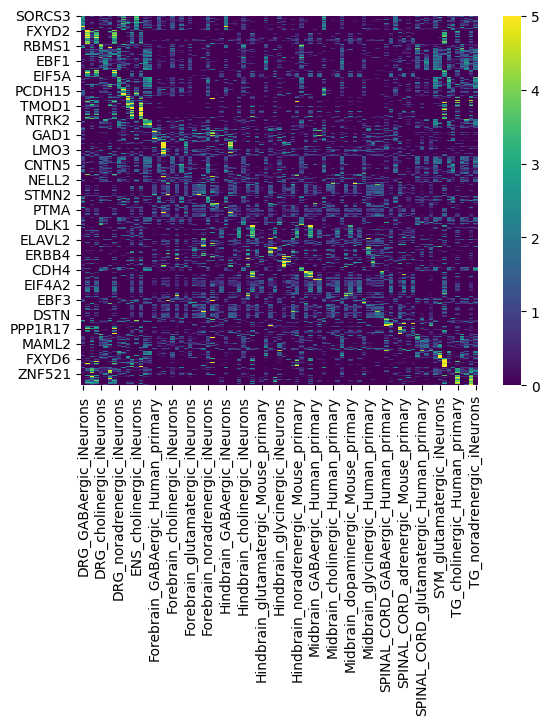

In [8]:
SC_expr_combined_plot = SC_expr_combined.loc[region_markers].copy()
SC_expr_combined_plot = (SC_expr_combined_plot.T-SC_expr_combined_plot.T.mean())/SC_expr_combined_plot.T.std()
SC_expr_combined_plot = SC_expr_combined_plot.T
sns.heatmap(SC_expr_combined_plot,vmin=0,vmax=5,cmap='viridis')

In [199]:
ineuron_nt_region_clusters = [x for x in SC_expr_combined.columns if 'iNeurons' in x]
hprim_nt_region_clusters = [x for x in SC_expr_combined.columns if 'primary' in x]

In [201]:
hprim_nt_region_clusters

['DRG_adrenergic_Mouse_primary',
 'DRG_cholinergic_Human_primary',
 'DRG_cholinergic_Mouse_primary',
 'DRG_histaminergic_Human_primary',
 'DRG_histaminergic_Mouse_primary',
 'ENS_cholinergic_Human_primary',
 'ENS_cholinergic_Mouse_primary',
 'ENS_dopaminergic_Mouse_primary',
 'Forebrain_GABAergic_Human_primary',
 'Forebrain_adrenergic_Human_primary',
 'Forebrain_cholinergic_Human_primary',
 'Forebrain_dopaminergic_Human_primary',
 'Forebrain_glutamatergic_Human_primary',
 'Forebrain_glycinergic_Human_primary',
 'Forebrain_histaminergic_Human_primary',
 'Forebrain_noradrenergic_Human_primary',
 'Forebrain_serotonergic_Human_primary',
 'Hindbrain_GABAergic_Human_primary',
 'Hindbrain_GABAergic_Mouse_primary',
 'Hindbrain_adrenergic_Human_primary',
 'Hindbrain_cholinergic_Human_primary',
 'Hindbrain_cholinergic_Mouse_primary',
 'Hindbrain_dopaminergic_Human_primary',
 'Hindbrain_dopaminergic_Mouse_primary',
 'Hindbrain_glutamatergic_Human_primary',
 'Hindbrain_glutamatergic_Mouse_primary'

<Axes: >

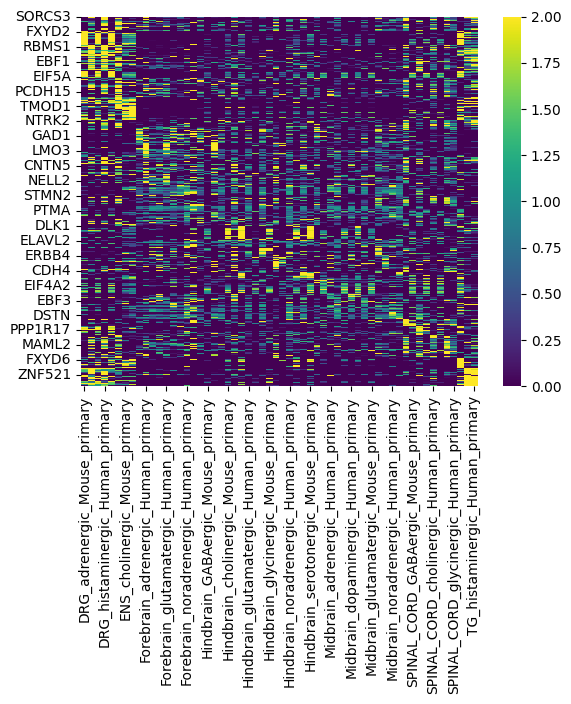

In [10]:
SC_expr_combined_plot = SC_expr_combined.loc[region_markers,hprim_nt_region_clusters].copy()
SC_expr_combined_plot = (SC_expr_combined_plot.T-SC_expr_combined_plot.T.mean())/SC_expr_combined_plot.T.std()
SC_expr_combined_plot = SC_expr_combined_plot.T
sns.heatmap(SC_expr_combined_plot,vmin=0,vmax=2,cmap='viridis')

<Axes: >

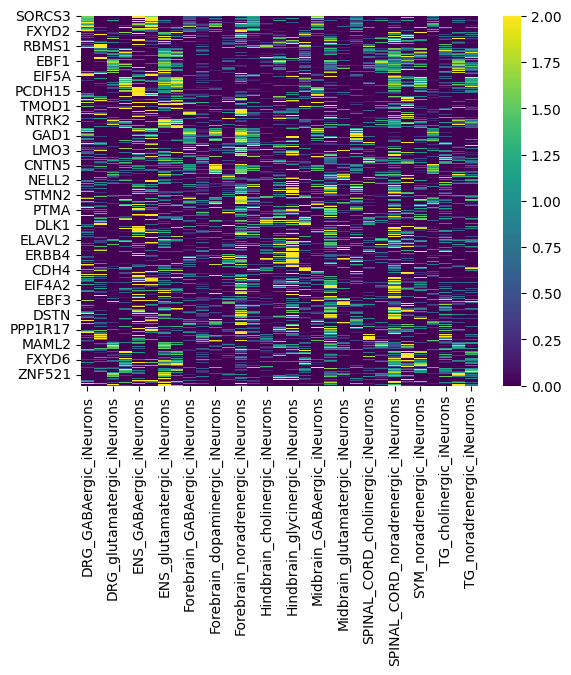

In [11]:
SC_expr_combined_plot = SC_expr_combined.loc[region_markers,ineuron_nt_region_clusters].copy()
SC_expr_combined_plot = (SC_expr_combined_plot.T-SC_expr_combined_plot.T.mean())/SC_expr_combined_plot.T.std()
SC_expr_combined_plot = SC_expr_combined_plot.T
sns.heatmap(SC_expr_combined_plot,vmin=0,vmax=2,cmap='viridis')

In [12]:
hprim_nt_region_clusters2 = [x for x in hprim_nt_region_clusters if 'Human' in x]
hprim_nt_region_clusters3 = [x for x in hprim_nt_region_clusters if 'SYM' in x]
hprim_nt_region_clusters = hprim_nt_region_clusters2 + hprim_nt_region_clusters3

In [13]:
import re

In [14]:
hprim_nt_region_clusters_types = [re.sub("_((Human)|(Mouse))_primary","",x) for x in hprim_nt_region_clusters]

In [15]:
ineuron_nt_region_clusters_types = [re.sub("_iNeurons","",x) for x in ineuron_nt_region_clusters]

In [196]:
shared_types = [x for x in ineuron_nt_region_clusters_types if x in hprim_nt_region_clusters_types]

In [198]:
hprim_nt_region_clusters_types

['DRG_cholinergic',
 'DRG_histaminergic',
 'ENS_cholinergic',
 'Forebrain_GABAergic',
 'Forebrain_adrenergic',
 'Forebrain_cholinergic',
 'Forebrain_dopaminergic',
 'Forebrain_glutamatergic',
 'Forebrain_glycinergic',
 'Forebrain_histaminergic',
 'Forebrain_noradrenergic',
 'Forebrain_serotonergic',
 'Hindbrain_GABAergic',
 'Hindbrain_adrenergic',
 'Hindbrain_cholinergic',
 'Hindbrain_dopaminergic',
 'Hindbrain_glutamatergic',
 'Hindbrain_glycinergic',
 'Hindbrain_histaminergic',
 'Hindbrain_noradrenergic',
 'Hindbrain_serotonergic',
 'Midbrain_GABAergic',
 'Midbrain_adrenergic',
 'Midbrain_cholinergic',
 'Midbrain_dopaminergic',
 'Midbrain_glutamatergic',
 'Midbrain_glycinergic',
 'Midbrain_histaminergic',
 'Midbrain_noradrenergic',
 'Midbrain_serotonergic',
 'SPINAL_CORD_GABAergic',
 'SPINAL_CORD_adrenergic',
 'SPINAL_CORD_cholinergic',
 'SPINAL_CORD_glutamatergic',
 'SPINAL_CORD_glycinergic',
 'TG_cholinergic',
 'TG_histaminergic',
 'SYM_noradrenergic']

## 12. Shared Cell Type Analysis

### Define Common Region-NT Combinations

Identify region-neurotransmitter combinations that are present in both primary neurons and iNeurons for direct comparative analysis.

In [17]:
shared_types = [
 'Forebrain_glutamatergic',
 'Forebrain_GABAergic',
 'Forebrain_cholinergic',
 'Forebrain_dopaminergic',
 'Forebrain_noradrenergic',
 'Midbrain_glutamatergic',
 'Midbrain_GABAergic',
 'Midbrain_cholinergic',

 'Hindbrain_glutamatergic',
 'Hindbrain_GABAergic',
 'Hindbrain_cholinergic',
 'Hindbrain_noradrenergic',
 'Hindbrain_glycinergic',


 'SPINAL_CORD_glutamatergic',
 'SPINAL_CORD_GABAergic',
 'SPINAL_CORD_cholinergic',
 'DRG_cholinergic',
 'TG_cholinergic',
 'SYM_noradrenergic',
 'ENS_cholinergic',]



In [18]:
shared_types_human = [x for x in shared_types if not 'SYM' in x]
shared_types_human = [x+"_Human_primary" for x in shared_types_human]

shared_types_mouse = [x for x in shared_types if 'SYM' in x]
shared_types_mouse = [x+"_Mouse_primary" for x in shared_types_mouse]
shared_types_primary = shared_types_human + shared_types_mouse

shared_types_primary = ['Forebrain_glutamatergic_Human_primary', 'Forebrain_GABAergic_Human_primary', 'Forebrain_cholinergic_Human_primary', 'Forebrain_dopaminergic_Human_primary', 'Forebrain_noradrenergic_Human_primary', 'Midbrain_glutamatergic_Human_primary', 'Midbrain_GABAergic_Human_primary', 'Midbrain_cholinergic_Human_primary', 'Hindbrain_glutamatergic_Human_primary', 'Hindbrain_GABAergic_Human_primary', 'Hindbrain_cholinergic_Human_primary', 'Hindbrain_noradrenergic_Human_primary', 'Hindbrain_glycinergic_Human_primary', 'SPINAL_CORD_glutamatergic_Human_primary', 'SPINAL_CORD_GABAergic_Human_primary', 'SPINAL_CORD_cholinergic_Human_primary', 'DRG_cholinergic_Human_primary', 'TG_cholinergic_Human_primary', 'SYM_noradrenergic_Mouse_primary','ENS_cholinergic_Human_primary']
shared_types_ineurons = [x+"_iNeurons" for x in shared_types]

In [19]:
shared_types_combined = shared_types_primary + shared_types_ineurons

In [139]:
cluster_counts = adata_subsampled.obs['region_NT'].value_counts()
cluster_counts_filtered = list(set(cluster_counts[cluster_counts>20].index))
adata_subsampled = adata_subsampled[adata_subsampled.obs['region_NT'].isin(cluster_counts_filtered)]
adata_subsampled = adata_subsampled[adata_subsampled.obs['region_NT_origin'].isin(shared_types_combined)]

sc.tl.rank_genes_groups(adata_subsampled, groupby='region_NT', method='wilcoxon',pts=True)
de_df_clusters = sc.get.rank_genes_groups_df(adata_subsampled,None)
de_df_clusters.to_csv("NT_comparison/region_NT_markers_final.tsv",sep="\t")

/cluster/home/jjanssens/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/cluster/home/jjanssens/.local/lib/python3.10/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


In [20]:
de_df_clusters = pd.read_csv("NT_comparison/region_NT_markers_final.tsv",sep="\t",index_col=0)

In [21]:
de_df_clusters['diff_pct'] = de_df_clusters['pct_nz_group']-de_df_clusters['pct_nz_reference']

In [22]:
de_df_clusters_pos = de_df_clusters.loc[de_df_clusters['pct_nz_group']>0.5].copy()

In [23]:
top_dmarkers = list(set(de_df_clusters_pos.sort_values(by='diff_pct',ascending=False).groupby('group').head(n=5)['names']))

In [24]:
# Get the top n markers per group
region_markers = list(de_df_clusters.groupby("group").head(n=50)['names'])

# Filter to keep only the first occurrence of each marker
region_markers_filtered = []
seen = set()

for marker in region_markers:
    if marker not in seen:
        region_markers_filtered.append(marker)
        seen.add(marker)
region_markers = region_markers_filtered 

In [114]:
group

'ENS_cholinergic'

### Optimized Marker Gene Selection

Select high-quality marker genes for each shared cell type based on differential expression criteria and expression percentage thresholds.

In [157]:
region_markers = []
for group in shared_types:
    print(group)
    de_df_cluster_group = de_df_clusters_pos.loc[de_df_clusters_pos['group']==group].copy()
    de_df_cluster_group = de_df_cluster_group.loc[de_df_cluster_group['diff_pct']>0]
    de_df_cluster_group = de_df_cluster_group.loc[de_df_cluster_group['logfoldchanges']>1]
    group_genes = list(de_df_cluster_group['names'][0:20])
    group_genes = [x for x in group_genes if x not in region_markers]


    SC_p_combined_group = SC_p_combined.loc[group_genes,[x for x in SC_p_combined.columns if group in x]]
    if not 'SYM' in group:
        group_clusters = [group+"_Human_primary",group+"_iNeurons"]
    if 'SYM' in group:
        group_clusters = [group+"_Mouse_primary",group+"_iNeurons"]

    ara = SC_p_combined_group[group_clusters].T.min()
    ara = ara[ara>50]
    if len(ara)>0:
        group_genes = list(ara.index)
        print(group_genes)
        if len(group_genes)>3:
            group_genes = group_genes[0:2]
        region_markers = region_markers + group_genes


Forebrain_glutamatergic
['CACNA2D1', 'SOX5', 'KCNQ3']
Forebrain_GABAergic
['NRXN3', 'DCLK2']
Forebrain_cholinergic
['SEMA6D', 'XKR4', 'AFF3', 'RIMS2', 'ANK2']
Forebrain_dopaminergic
['DCC', 'ADARB2', 'NEGR1', 'DSCAM', 'SLC8A1', 'CNTNAP2', 'PTPRD', 'NRG3', 'DPP6', 'CAMTA1', 'MSI2', 'NRG1', 'PRKACB']
Forebrain_noradrenergic
['DPP6', 'NCAM2', 'PTPRG', 'PRICKLE2', 'NBEA', 'ROBO2']
Midbrain_glutamatergic
['EBF1', 'EBF3', 'DAB1', 'NRG3', 'ROBO1', 'NAV2', 'ZNF521']
Midbrain_GABAergic
['DSCAM']
Midbrain_cholinergic
['NEFM', 'GAP43', 'SLIT2', 'ATP2B1', 'ELAVL2', 'ELAVL4']
Hindbrain_glutamatergic
['TSHZ2', 'NAV2', 'MEIS2']
Hindbrain_GABAergic
['DNER', 'FSTL5', 'RTN1']
Hindbrain_cholinergic
['FRMD4A', 'AUTS2', 'PBX3', 'AKAP6', 'RIMS2']
Hindbrain_noradrenergic
['FGF13', 'HS3ST5', 'CACNA1C']
Hindbrain_glycinergic
['NOVA1', 'ZFHX3', 'CACNA2D3', 'MEIS1', 'PHYHIPL', 'ERBB4', 'SRGAP3']
SPINAL_CORD_glutamatergic
['CACNA1A', 'SPOCK1', 'NAV3', 'MTUS2', 'KIRREL3', 'NLGN1', 'CSMD1', 'NTRK2', 'GFRA1', 'MAML2

In [158]:
#filter marker genes and convert to regulon format
import pyscenic as ps
consensus_regulons = []
all_NT_genes = []
for NT in ['glutamatergic', 'GABAergic', 'cholinergic','dopaminergic','noradrenergic',  'adrenergic', 'glycinergic']:
    print(NT)
    NT_genes = regulons[NT]
    regulon_dict = {}
    print(NT_genes)
    NT_genes = [x for x in NT_genes if x in SC_expr_combined.index]
    print(NT_genes)
    for gene in NT_genes:
        regulon_dict[gene] = 1
    all_NT_genes = all_NT_genes + NT_genes

glutamatergic
['SLC1A1', 'SLC1A2', 'SLC1A6', 'SLC17A6', 'SLC17A7', 'SLC17A8']
['SLC1A1', 'SLC1A2', 'SLC1A6', 'SLC17A6', 'SLC17A7', 'SLC17A8']
GABAergic
['GAD1', 'GAD2', 'SLC32A1', 'SLC6A1']
['GAD1', 'GAD2', 'SLC6A1']
cholinergic
['SLC18A3', 'CHAT', 'ACHE']
['CHAT', 'ACHE']
dopaminergic
['TYR', 'DDC', 'SLC18A2', 'SLC18A3', 'SLC6A2']
['TYR', 'DDC', 'SLC18A2', 'SLC6A2']
noradrenergic
['DBH', 'SLC6A2']
['DBH', 'SLC6A2']
adrenergic
['PNMT']
['PNMT']
glycinergic
['SLC6A5', 'SLC6A9']
['SLC6A5', 'SLC6A9']


In [159]:
region_markers_plot = region_markers + all_NT_genes

## 13. Comparative Expression Heatmaps

### Primary Neuron Expression Patterns

Generate standardized heatmaps showing expression patterns of selected marker genes across primary neuron populations from different brain regions and neurotransmitter types.

In [178]:
mpl.rcParams['pdf.fonttype'] = 42

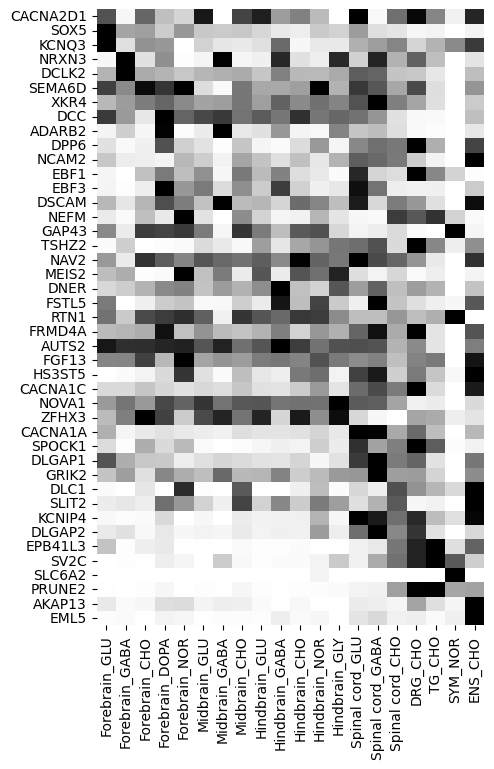

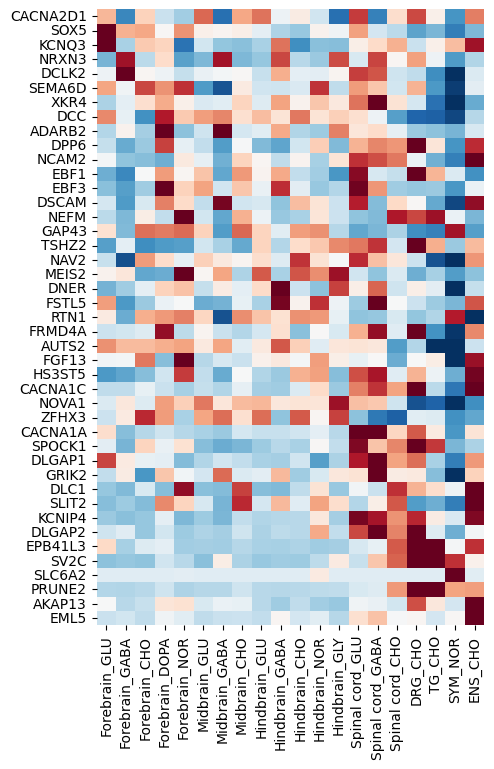

In [182]:
SC_expr_combined_plot = SC_expr_combined.loc[region_markers,shared_types_primary].copy()
SC_expr_combined_plot.columns = [re.sub("_Human.*","",x) for x in SC_expr_combined_plot.columns]
SC_expr_combined_plot.columns = [re.sub("_Mouse.*","",x) for x in SC_expr_combined_plot.columns]

SC_expr_combined_plot.columns = [re.sub("glutamatergic","GLU",x) for x in SC_expr_combined_plot.columns]
SC_expr_combined_plot.columns = [re.sub("GABAergic","GABA",x) for x in SC_expr_combined_plot.columns]
SC_expr_combined_plot.columns = [re.sub("noradrenergic","NOR",x) for x in SC_expr_combined_plot.columns]
SC_expr_combined_plot.columns = [re.sub("glycinergic","GLY",x) for x in SC_expr_combined_plot.columns]
SC_expr_combined_plot.columns = [re.sub("dopaminergic","DOPA",x) for x in SC_expr_combined_plot.columns]
SC_expr_combined_plot.columns = [re.sub("SPINAL_CORD","Spinal cord",x) for x in SC_expr_combined_plot.columns]
SC_expr_combined_plot.columns = [re.sub("cholinergic","CHO",x) for x in SC_expr_combined_plot.columns]


SC_expr_combined_plot_mm = (SC_expr_combined_plot.T-SC_expr_combined_plot.T.min())/(SC_expr_combined_plot.T.max()-SC_expr_combined_plot.T.min())
SC_expr_combined_plot_mm = SC_expr_combined_plot_mm.T


SC_expr_combined_plot = (SC_expr_combined_plot.T-SC_expr_combined_plot.T.mean())/SC_expr_combined_plot.T.std()
SC_expr_combined_plot = SC_expr_combined_plot.T
plt.figure(figsize=(5,8))
sns.heatmap(SC_expr_combined_plot_mm,vmin=0,vmax=1,cmap='Greys',cbar=False)
plt.savefig("NT_comparison_primary_sharedmarkers_minmax.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.savefig("NT_comparison_primary_sharedmarkers_minmax.pdf",dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()

plt.figure(figsize=(5,8))
sns.heatmap(SC_expr_combined_plot,vmin=-2,vmax=2,cmap='RdBu_r',cbar=False)
plt.savefig("NT_comparison_primary_sharedmarkers.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.savefig("NT_comparison_primary_sharedmarkers.pdf",dpi=350,bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()

### iNeuron Expression Patterns

Generate corresponding heatmaps for iNeuron populations using the same marker genes and visualization parameters for direct comparison with primary neurons.

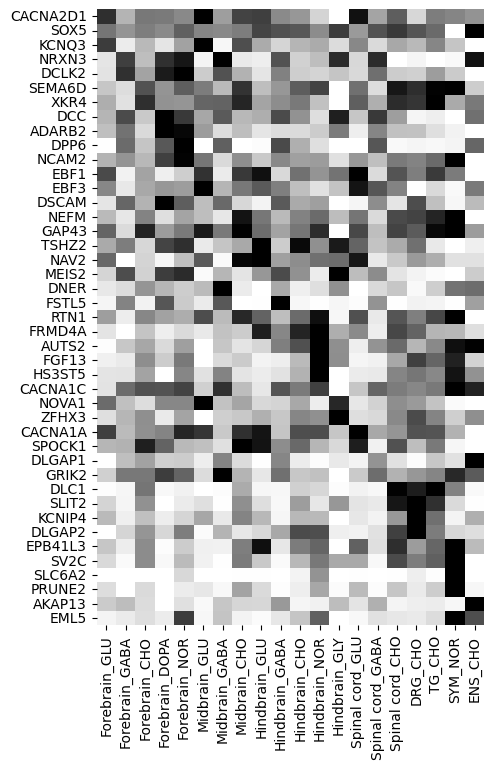

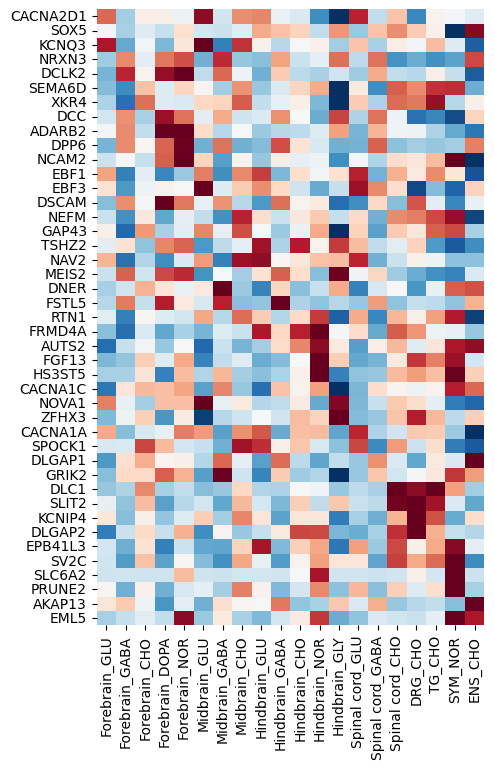

In [181]:
SC_expr_combined_plot = SC_expr_combined.loc[region_markers,shared_types_ineurons].copy()
SC_expr_combined_plot.columns = [re.sub("_iNeurons","",x) for x in SC_expr_combined_plot.columns]
SC_expr_combined_plot.columns = [re.sub("glutamatergic","GLU",x) for x in SC_expr_combined_plot.columns]
SC_expr_combined_plot.columns = [re.sub("GABAergic","GABA",x) for x in SC_expr_combined_plot.columns]
SC_expr_combined_plot.columns = [re.sub("noradrenergic","NOR",x) for x in SC_expr_combined_plot.columns]
SC_expr_combined_plot.columns = [re.sub("glycinergic","GLY",x) for x in SC_expr_combined_plot.columns]
SC_expr_combined_plot.columns = [re.sub("dopaminergic","DOPA",x) for x in SC_expr_combined_plot.columns]
SC_expr_combined_plot.columns = [re.sub("SPINAL_CORD","Spinal cord",x) for x in SC_expr_combined_plot.columns]
SC_expr_combined_plot.columns = [re.sub("cholinergic","CHO",x) for x in SC_expr_combined_plot.columns]


SC_expr_combined_plot_mm = (SC_expr_combined_plot.T-SC_expr_combined_plot.T.min())/(SC_expr_combined_plot.T.max()-SC_expr_combined_plot.T.min())
SC_expr_combined_plot_mm = SC_expr_combined_plot_mm.T

SC_expr_combined_plot = (SC_expr_combined_plot.T-SC_expr_combined_plot.T.mean())/SC_expr_combined_plot.T.std()
SC_expr_combined_plot = SC_expr_combined_plot.T
plt.figure(figsize=(5,8))
sns.heatmap(SC_expr_combined_plot_mm,vmin=0,vmax=1,cmap='Greys',cbar=False)
plt.savefig("NT_comparison_iNeurons_sharedmarkers_minmax.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.savefig("NT_comparison_iNeurons_sharedmarkers_minmax.pdf",dpi=350,bbox_inches='tight',pad_inches=0)

plt.show()
plt.close()

plt.figure(figsize=(5,8))
sns.heatmap(SC_expr_combined_plot,vmin=-2,vmax=2,cmap='RdBu_r',cbar=False)
plt.savefig("NT_comparison_iNeurons_sharedmarkers.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.savefig("NT_comparison_iNeurons_sharedmarkers.pdf",dpi=350,bbox_inches='tight',pad_inches=0)

plt.show()
plt.close()

### Diagonal Comparison Visualization

Create a split-diagonal heatmap that directly compares primary neurons (left triangles) and iNeurons (right triangles) within the same visualization for easy side-by-side comparison.

In [183]:
SC_expr_combined_plot = SC_expr_combined.loc[region_markers,shared_types_primary].copy()
SC_expr_combined_plot_mm = (SC_expr_combined_plot.T-SC_expr_combined_plot.T.min())/(SC_expr_combined_plot.T.max()-SC_expr_combined_plot.T.min())
SC_expr_combined_plot_mm = SC_expr_combined_plot_mm.T
SC_expr_combined_plot_primary = SC_expr_combined_plot_mm

SC_expr_combined_plot = SC_expr_combined.loc[region_markers,shared_types_ineurons].copy()
SC_expr_combined_plot_mm = (SC_expr_combined_plot.T-SC_expr_combined_plot.T.min())/(SC_expr_combined_plot.T.max()-SC_expr_combined_plot.T.min())
SC_expr_combined_plot_mm = SC_expr_combined_plot_mm.T
SC_expr_combined_plot_ineurons = SC_expr_combined_plot_mm


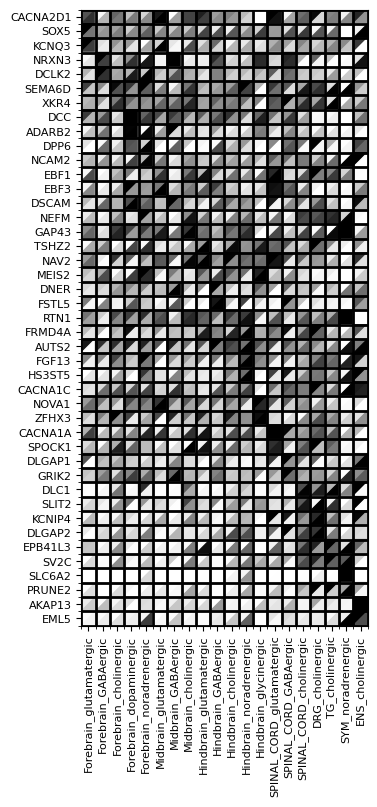

In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import re  # If needed for column renaming

# Example data
df1 = SC_expr_combined_plot_primary.copy()
df2 = SC_expr_combined_plot_ineurons.copy()

df1.columns = [re.sub("_Human_primary", "", x) for x in df1.columns]
df1.columns = [re.sub("_Mouse_primary", "", x) for x in df1.columns]

df2.columns = [re.sub("_iNeurons", "", x) for x in df2.columns]

# Define the dimensions
rows, cols = df1.shape

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Set up a color scale
cmap = plt.get_cmap('Greys')

# Loop through each cell
for i in range(rows):
    for j in range(cols):
        # Get the values from each dataframe
        val1 = df1.iloc[i, j]
        val2 = df2.iloc[i, j]
        
        # Normalize the values for the color map
        norm_val1 = (val1 - df1.min().min()) / (df1.max().max() - df1.min().min())
        norm_val2 = (val2 - df2.min().min()) / (df2.max().max() - df2.min().min())

        norm_val1 = val1
        norm_val2 = val2
        # Define the coordinates of the square (centered on (j, i))
        x = j
        y = i

        # Create left triangle (for df1 values)
        left_triangle = Polygon([[x - 0.5, y - 0.5], [x + 0.5, y - 0.5], [x - 0.5, y + 0.5]],
                                color=cmap(norm_val1))
        ax.add_patch(left_triangle)

        # Create right triangle (for df2 values)
        right_triangle = Polygon([[x + 0.5, y + 0.5], [x + 0.5, y - 0.5], [x - 0.5, y + 0.5]],
                                 color=cmap(norm_val2))
        ax.add_patch(right_triangle)

# Add gene names (index of df1) as labels for y-axis
ax.set_yticks(np.arange(rows))
ax.set_yticklabels(df1.index, fontsize=8)  # Adjust fontsize if needed

# Add cluster labels (columns of df1 and df2) as labels for x-axis
ax.set_xticks(np.arange(cols))
ax.set_xticklabels(df1.columns, rotation=90, fontsize=8)  # Rotate for better readability

# Adjust the limits and aspect ratio
ax.set_xlim(-0.5, cols - 0.5)
ax.set_ylim(rows - 0.5, -0.5)
ax.set_aspect('equal')

# Add grid lines
ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

# Optionally add colorbar for reference
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])  # dummy array for colorbar

# Save the figure
plt.savefig("NT_comparison_iNeurons_sharedmarkers_diagon.png", dpi=350, bbox_inches='tight', pad_inches=0)
plt.savefig("NT_comparison_iNeurons_sharedmarkers_diagon.pdf", dpi=350, bbox_inches='tight', pad_inches=0)

plt.show()
plt.close()


## 14. Correlation Analysis

### Calculate Expression Correlations

Compute Pearson correlations between primary neurons and iNeurons to quantify the similarity of expression patterns across matched cell types.

In [173]:
df_for_corr = pd.merge(SC_expr_combined_plot_ineurons,SC_expr_combined_plot_primary,left_index=True,right_index=True)

In [174]:
df_for_corr = df_for_corr.corr(method='pearson')

<Axes: >

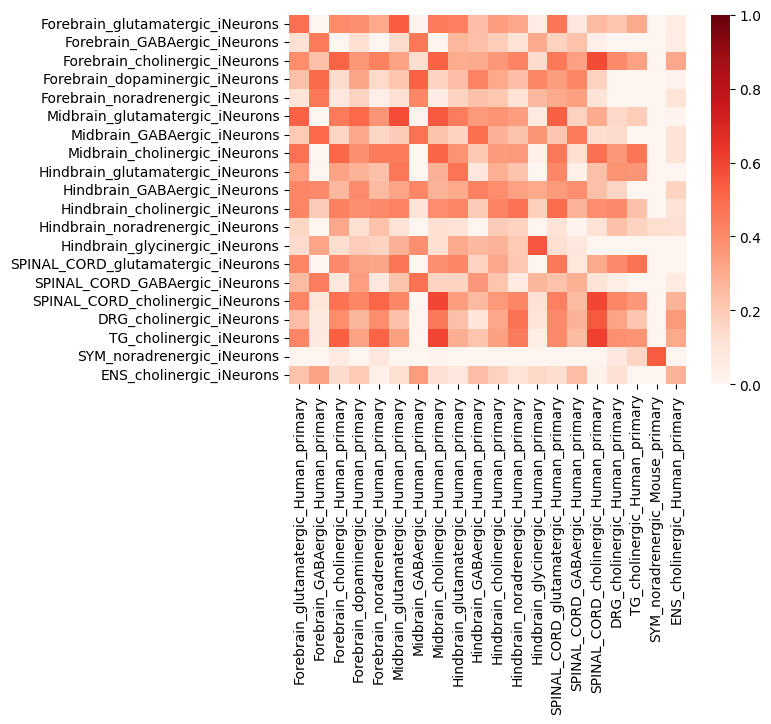

In [175]:
sns.heatmap(df_for_corr.loc[shared_types_ineurons,shared_types_primary],vmin=0,vmax=1,cmap='Reds')

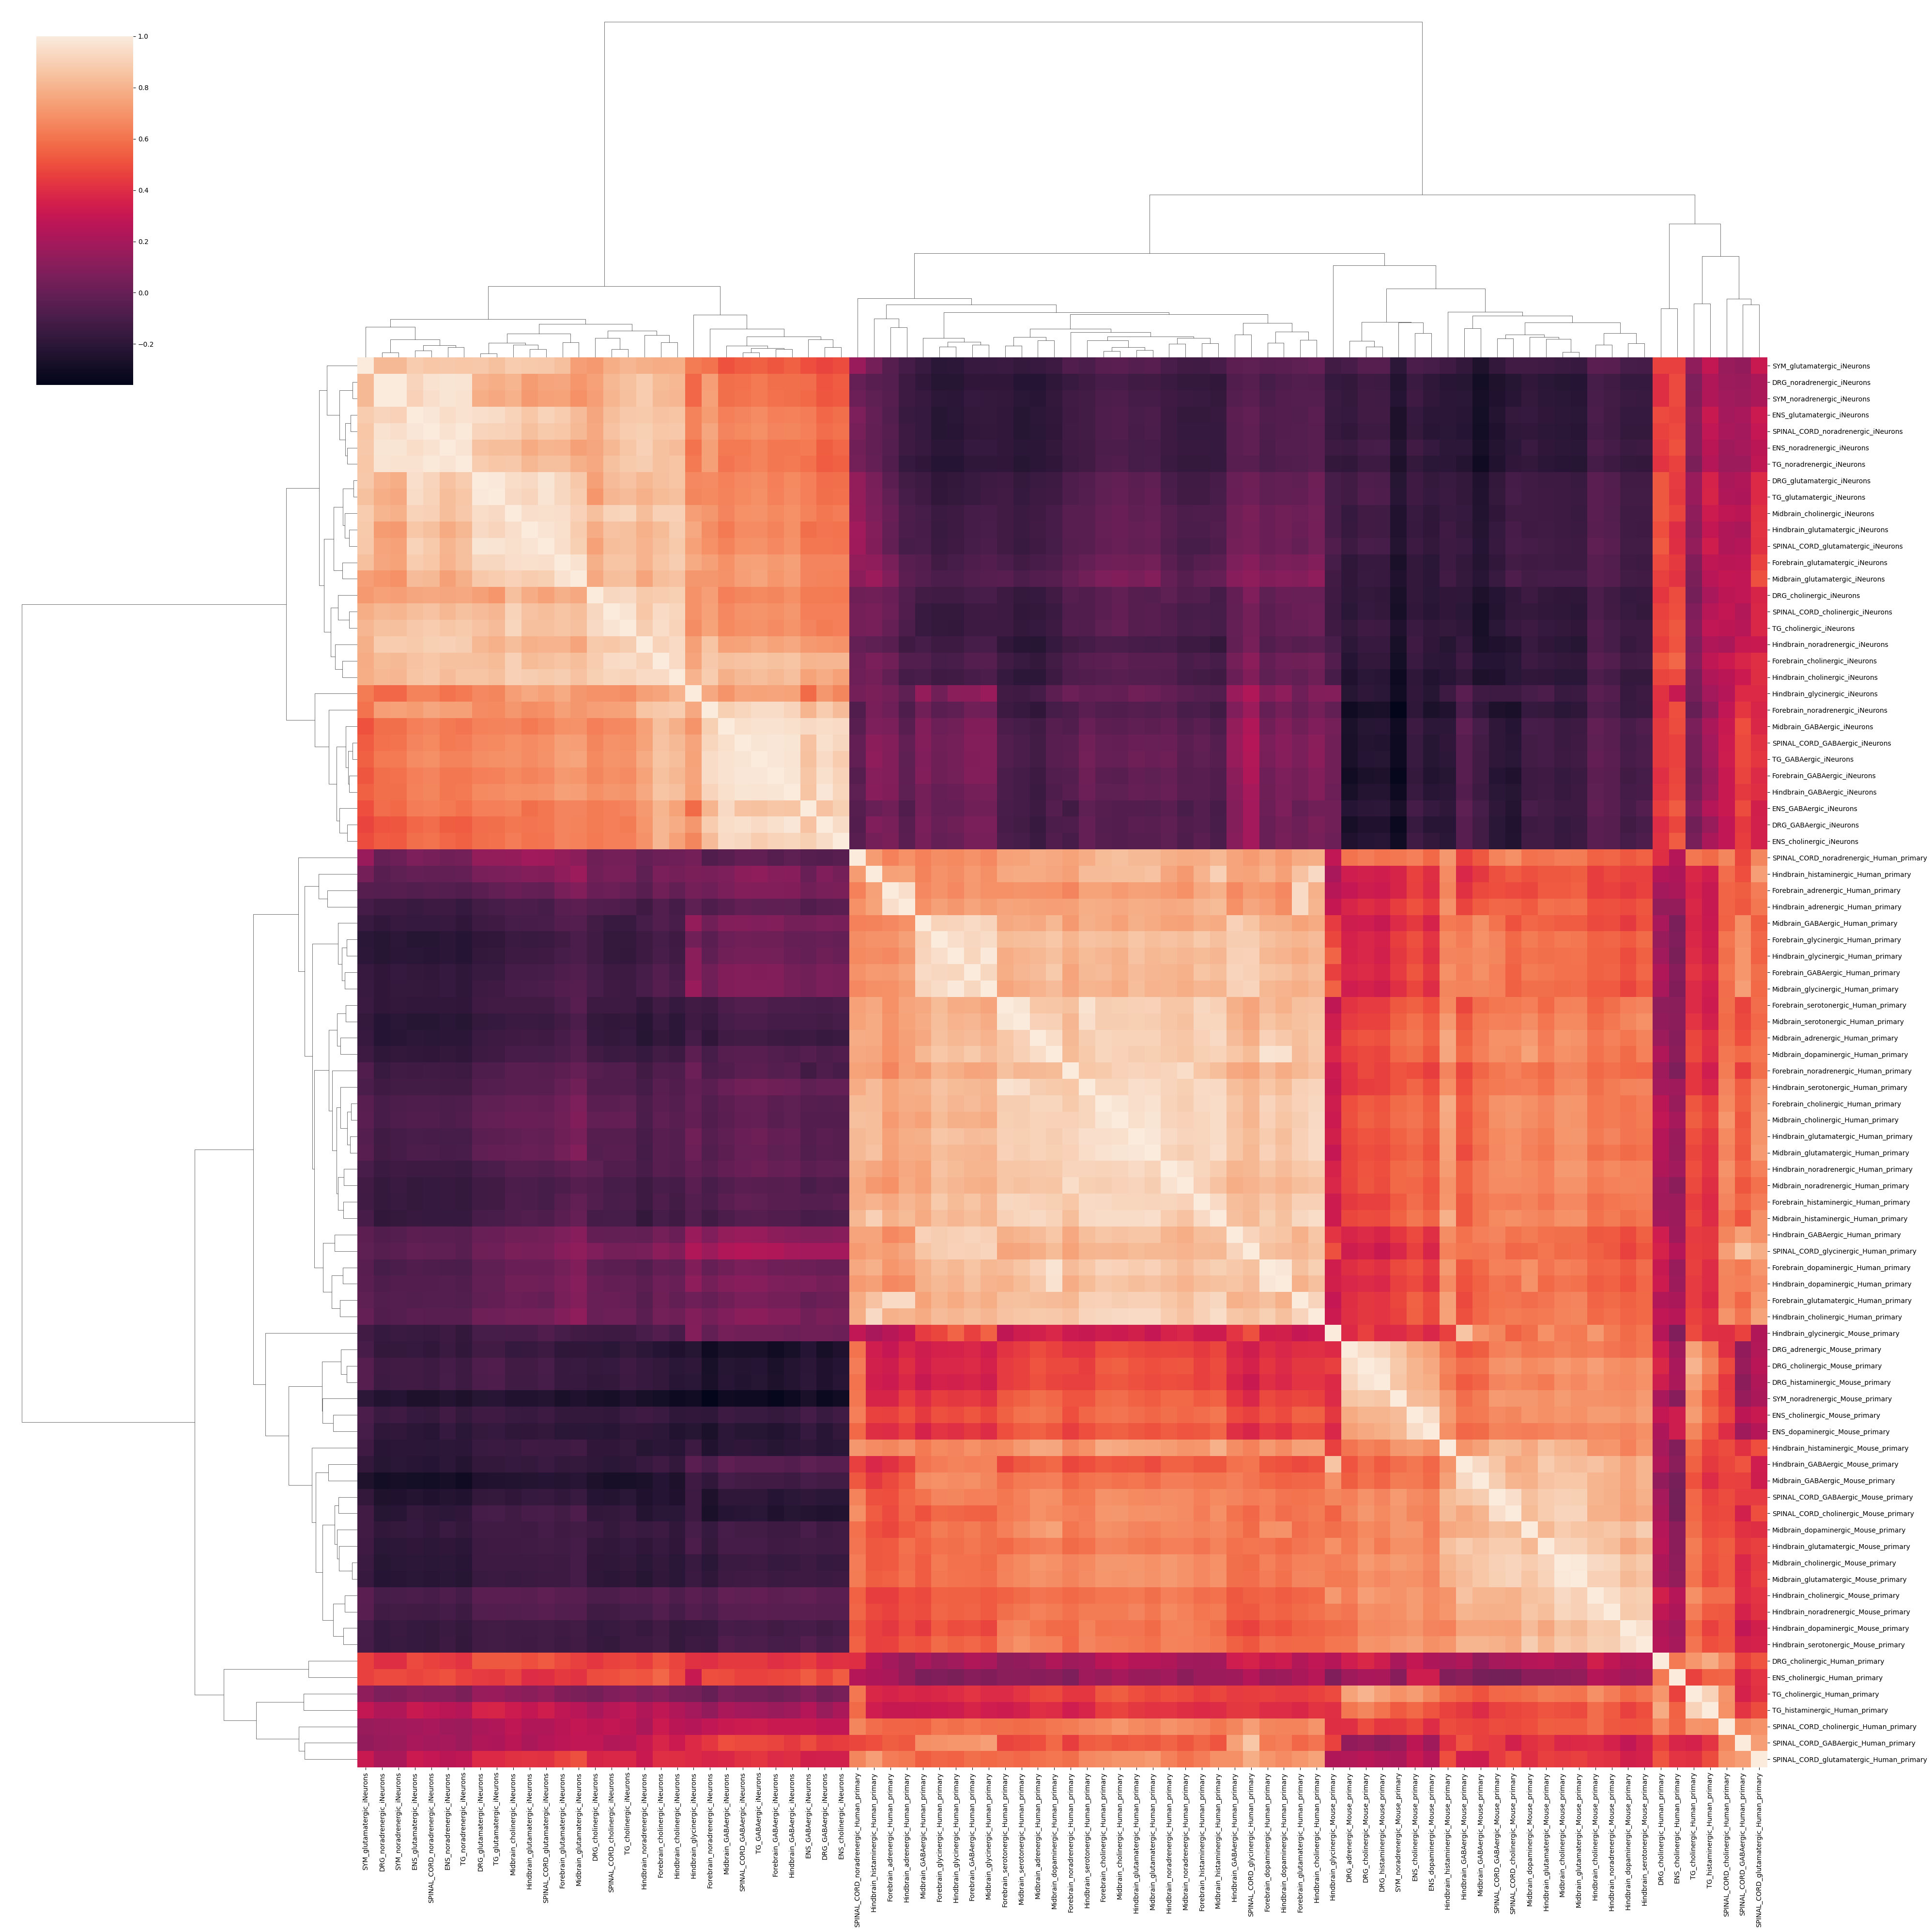

In [129]:
sns.clustermap(SC_expr_combined.loc[region_markers].corr(),figsize=(40,40))